In [6]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML

pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

data_dir = "data/"

#def present_dataframe(df):


## Citywide Payrolls

Here are the total salaries and overtime wages for all city agencies.

In [13]:
payroll = pd.read_csv("data/Citywide_Payroll_Data__Fiscal_Year_.csv")
payroll_counts = pd.pivot_table(payroll[payroll["Fiscal Year"]==2019][['Agency Name', 'Base Salary', 'Total OT Paid']], index="Agency Name", aggfunc=np.sum).reset_index()
payroll_counts["Total"] = payroll_counts["Base Salary"] + payroll_counts["Total OT Paid"]
payroll_counts.sort_values(by="Total", ascending=False)

,Agency Name,Base Salary,Total OT Paid,Total
70,DEPT OF ED PEDAGOGICAL,"10,504,985,856.00",0.00,"10,504,985,856.00"
126,POLICE DEPARTMENT,"4,109,923,694.94","727,903,579.28","4,837,827,274.22"
89,FIRE DEPARTMENT,"1,370,356,437.33","340,735,452.35","1,711,091,889.68"
69,DEPT OF ED PARA PROFESSIONALS,"1,178,122,166.62","2,260,994.20","1,180,383,160.82"
60,DEPARTMENT OF CORRECTION,"941,265,074.17","181,879,757.19","1,123,144,831.36"
61,DEPARTMENT OF EDUCATION ADMIN,"970,756,081.15","23,487,434.91","994,243,516.06"
92,HRA/DEPT OF SOCIAL SERVICES,"822,975,390.68","39,013,197.27","861,988,587.95"
65,DEPARTMENT OF SANITATION,"721,506,251.09","138,605,350.42","860,111,601.51"
115,NYC HOUSING AUTHORITY,"529,548,680.15","95,529,398.97","625,078,079.12"
0,ADMIN FOR CHILDREN'S SVCS,"558,516,930.57","61,342,038.11","619,858,968.68"


In [14]:
teacher_payroll = payroll[payroll["Agency Name"]=="DEPT OF ED PEDAGOGICAL"]
teacher_payroll = teacher_payroll[teacher_payroll["Fiscal Year"]==2019]
total_teachers = len(teacher_payroll)
# display(HTML("<h3>Total Department of Education Employees: {}".format(total_teachers)))

In [15]:
cop_payroll = payroll[payroll["Agency Name"] == "POLICE DEPARTMENT"]
cop_payroll = cop_payroll[cop_payroll["Fiscal Year"] == 2019]
total_cops = len(cop_payroll)
# display(HTML("<h3>Total Police Department Employees: {}".format(total_cops)))

## Police Payroll Sorted by Total Overtime Paid, 2019 (rows 0-2000)

It's interesting to look at police payments, here sorted by individual total overtime paid out.

In [17]:
cop_payroll[['Title Description', 'Base Salary', 'Regular Gross Paid', 'Total Other Pay', 'Total OT Paid']].sort_values(by="Total OT Paid", ascending=False)[0:2000]

,Title Description,Base Salary,Regular Gross Paid,Total Other Pay,Total OT Paid
3313649,POLICE OFFICER D/A DETECTIVE 2ND GR,"109,360.00","107,524.64","20,979.07","103,091.60"
3284392,STATIONARY ENGINEER,486.72,"126,547.20","17,963.45","101,740.00"
3328794,STATIONARY ENGINEER,486.72,"126,547.20","34,802.95","100,332.68"
3305370,STATIONARY ENGINEER,486.72,"126,547.20","13,962.23","87,938.10"
3315423,STATIONARY ENGINEER,486.72,"126,547.20","32,732.04","84,850.46"
3282816,STATIONARY ENGINEER,486.72,"126,547.20","36,211.70","84,292.44"
3320054,POLICE OFFICER D/A DETECTIVE 1ST GR,"125,531.00","123,424.25","27,377.49","81,205.25"
3287950,SENIOR STATIONARY ENGINEER,577.68,"150,196.80",0.00,"77,941.73"
3280324,SUPERVISOR PLUMBER,387.03,"101,270.05",0.00,"76,366.22"
3285628,SENIOR STATIONARY ENGINEER,577.68,"150,196.80","1,606.68","76,262.94"


Here's a quick summary of police payroll:

In [18]:
total_dollars = cop_payroll["Regular Gross Paid"].sum() + cop_payroll["Total Other Pay"].sum() + cop_payroll["Total OT Paid"].sum()
# total_dollars = cop_payroll["Base Salary"].sum() + cop_payroll["Total OT Paid"].sum()

print("total base:", f'{cop_payroll["Base Salary"].sum():,}')
print("total gross:", f'{cop_payroll["Regular Gross Paid"].sum():,}')
print("total other:", f'{cop_payroll["Total Other Pay"].sum():,}')
print("total OT:", f'{cop_payroll["Total OT Paid"].sum():,}')
print("OT hours:", f'{cop_payroll["OT Hours"].sum():,}')
print("total $$$:", f'{total_dollars:,}')

total base: 4,109,923,694.94
total gross: 3,895,716,912.5
total other: 538,739,298.94
total OT: 727,903,579.2800001
OT hours: 11,597,478.129999999
total $$$: 5,162,359,790.72


## Arrests in 2019

In [21]:
arrest_data = pd.read_csv("data/NYPD_Arrests_Data__Historic_.csv")
arrests_2019 = arrest_data[arrest_data['ARREST_DATE'].str.contains('2019')]

### Count of Level of offense (2019): felony, misdemeanor, violation

The vast majority of arrests are for misdemeanors.

In [102]:
arrest_cats = pd.DataFrame(arrests_2019['LAW_CAT_CD'].value_counts())
#arrest_cats.index["M"] = "Misdemeanor"
arrest_cats.rename(index = {"M": "Misdemeanor", "F":"Felony", "V": "Violation"}, inplace=True)
#arrest_cats.columns["LAW_CAT_CD"] = "Category"
arrest_cats

,LAW_CAT_CD
Misdemeanor,126609
Felony,83384
Violation,2822
I,433


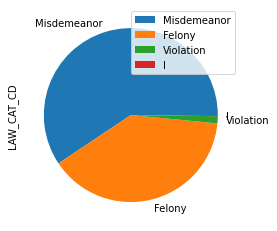

In [97]:
arrest_cats.plot(kind='pie', y=0)

The police describe a general description of each type of arrest. Here are the totals for 2019.

In [24]:
arrest_counts = pd.DataFrame(arrests_2019['OFNS_DESC'].value_counts()).reset_index()
arrest_counts.columns = ["Offense Type", "Total Arrests"]
arrest_counts

,Offense Type,Total Arrests
0,ASSAULT 3 & RELATED OFFENSES,31988
1,PETIT LARCENY,21627
2,DANGEROUS DRUGS,21071
3,FELONY ASSAULT,15208
4,VEHICLE AND TRAFFIC LAWS,14243
5,MISCELLANEOUS PENAL LAW,12325
6,CRIMINAL MISCHIEF & RELATED OF,9971
7,GRAND LARCENY,9913
8,ROBBERY,9259
9,DANGEROUS WEAPONS,7921


In [25]:
#arrest_counts_pd = arrests_2019['PD_DESC'].value_counts()
#arrest_counts_pd

### Notes on crime types:

1. The lowest-level theft offense in New York is called "petit larceny," or petty theft, which is the unlawful taking of property or services valued at no more than $1,000

2. Each arrest costs around 24,000 in person hours, or 519,048,000 total for all petty theft arrests. Let's say that each petit theft was in fact for the maximum 1000, meaning the total value of goods stolen is 21,627,000. This means that if the city simply reimbursed for lost property instead of arresting people it would save New York 497,421,000.

3. "assault 3" is assault in the 3rd degree: "Assault in the third degree is the top charge when there are only minor injuries, weapons are not used, and the victim does not fall into a special protected category" (SCUFFLES)

4. Escape 3: A person is guilty of escape in the third degree when he escapes from custody!

5. I am confused about "OFFENSES AGAINST PUBLIC ADMINI" - it seems to encompass a ton of stuff

6. "Theft of services" (4194 arrests) can include riding public transit without a pass

In [18]:
human_dollars_per_arrest = total_dollars / len(arrests_2019)
human_dollars_per_arrest

24053.825143022223

## Complaint Data

The police also provide a data about criminal complaints. These are calls that people make to 911 that may or may not lead to arrests.

In [26]:
# load historical complaint data
complaint_data = pd.read_csv(data_dir + "NYPD_Complaint_Data_Historic.csv")
# complaint_data.head()

### Attempted vs Completed Crimes

One interesting column in the complaint data is "CRM_ATPT_CPTD_CD", which indicates "whether crime was successfully completed or attempted, but failed or was interrupted prematurely". Using this data we can see the total number of crimes that the police were potentially able to stop. It's 2%.

In [48]:
completed_crime_counts = pd.DataFrame(complaint_data["CRM_ATPT_CPTD_CD"].value_counts()).reset_index()
completed_crime_counts.columns = ["Crime Status", "Total"]
completed_crime_counts

,Crime Status,Total
0,COMPLETED,7184747
1,ATTEMPTED,124901


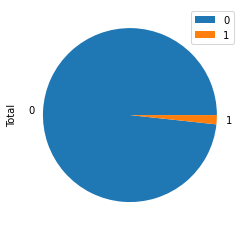

In [53]:
completed_crime_counts.plot(kind='pie', y=1)

The police also have an interesting method of marking the gender of victims.

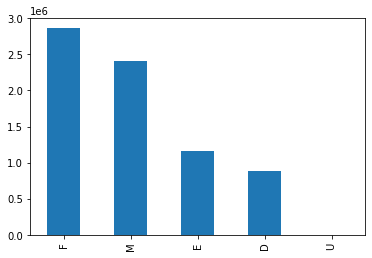

In [55]:
complaint_data["VIC_SEX"].value_counts().plot(kind='bar')

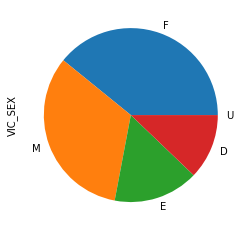

In [56]:
complaint_data["VIC_SEX"].value_counts().plot(kind='pie')